# Loading Dependencies

In [92]:
import cv2
import numpy as np
import os 
import matplotlib.pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
import os
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
import pandas as pd
import time
import mediapipe as mp


# Preprocessing and Creating Labels and Features

In [93]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [94]:
mp_holistic = mp.solutions.holistic #Holistic Model
mp_drawing = mp.solutions.drawing_utils #Drawing utilities

In [95]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_DATA')

# Actions that will be detected
actions = np.array(['Magandang Umaga', 'Magandang Hapon', 'Magandang Gabi'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [96]:
label_map = {label: num for num, label in enumerate(actions)}

In [97]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [98]:
x = np.array(sequences)
y = to_categorical(labels).astype(int)

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

# Build and Train LSTM Neural Network

In [100]:
del model

In [101]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

In [102]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [103]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [104]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [105]:
history = model.fit(x_train, y_train, epochs=2000)

Epoch 1/2000
3/3 [==============================] - 4s 79ms/step - loss: 1.2383 - categorical_accuracy: 0.3412
Epoch 2/2000
3/3 [==============================] - 0s 80ms/step - loss: 1.4064 - categorical_accuracy: 0.4235
Epoch 3/2000
3/3 [==============================] - 0s 77ms/step - loss: 2.8975 - categorical_accuracy: 0.2941
Epoch 4/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.4629 - categorical_accuracy: 0.2941
Epoch 5/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.8150 - categorical_accuracy: 0.3882
Epoch 6/2000
3/3 [==============================] - 0s 78ms/step - loss: 5.3003 - categorical_accuracy: 0.1765
Epoch 7/2000
3/3 [==============================] - 0s 77ms/step - loss: 2.1934 - categorical_accuracy: 0.2941
Epoch 8/2000
3/3 [==============================] - 0s 80ms/step - loss: 1.1639 - categorical_accuracy: 0.5412
Epoch 9/2000
3/3 [==============================] - 0s 76ms/step - loss: 2.4533 - categorical_accuracy: 0.3059
E

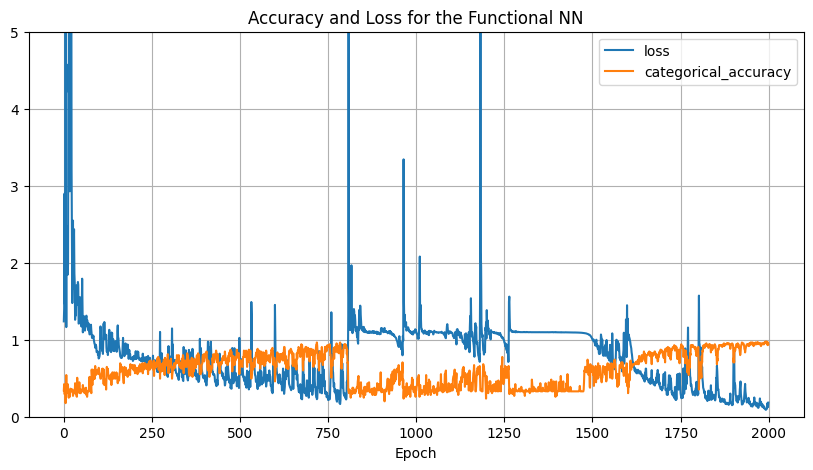

In [108]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.ylim(0,5)
plt.title('Accuracy and Loss for the Functional NN')
plt.xlabel('Epoch')
plt.show()

In [109]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 422ms/step - loss: 0.0506 - categorical_accuracy: 1.0000


[0.050645072013139725, 1.0]

# Test in Real Time

In [111]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [112]:
def mediapipe_detection(image, model):

    '''Function to connect webcam to cv to gather images'''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion from BGR to RGB
    image.flags.writeable = False                   # Prevents writing to image
    results = model.process(image)                  # Make predictions using the model
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Color conversion from RGB to BGR

    return image, results

def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    # Draw pose connections 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    # Draw right hand connections 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)


def draw_styled_landmarks(image, results):
    '''Function to draw styled the landmarks on the face, hands, and pose'''

     # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                            )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=1)
                            )
    # Draw left hand connections 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                            )
    # Draw right hand connections 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(245,118,66), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1)
                            ) 


def extract_keypoints(results):
    '''Function to extract keypoints from the 
    face, pose, and hands using mediapipe'''
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)

    return np.concatenate([pose, face, lh, rh])

In [115]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.9

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti